<a href="https://colab.research.google.com/github/nitixsh/CNN-BILSTM_IDS-Project/blob/main/CNN-BILSTM_IDS-Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **STEP 0 — Install & Import (Colab)**

In [6]:
!pip install pyswarms


In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Dense, Conv1D, MaxPooling1D, LSTM,
    Bidirectional, Dropout, Input
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import pyswarms as ps


# **STEP 1 — Load YOUR UNSW-NB15 Dataset**

In [8]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
train_path = "/content/UNSW_NB15_training-set.csv"
test_path  = "/content/UNSW_NB15_testing-set.csv"

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

print(train_df.shape, test_df.shape)


(175341, 45) (82332, 45)


# **STEP 2 — Preprocessing**

In [10]:
drop_cols = ['id', 'proto', 'service', 'state']
train_df.drop(columns=drop_cols, inplace=True)
test_df.drop(columns=drop_cols, inplace=True)


In [11]:
y_train = train_df['label']
y_test  = test_df['label']

X_train = train_df.drop(columns=['label', 'attack_cat'])
X_test  = test_df.drop(columns=['label', 'attack_cat'])


# **STEP 3 — Standardization**

In [12]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)



# **STEP 4 — PSO Feature Selection**

In [13]:
def pso_fitness(particles):
    scores = []

    for particle in particles:
        mask = particle > 0.5
        if mask.sum() < 5:
            scores.append(1.0)
            continue

        X_sel = X_train_scaled[:, mask]
        X_sel = X_sel.reshape(X_sel.shape[0], X_sel.shape[1], 1)

        model = Sequential([
            Conv1D(32, 3, activation='relu', input_shape=X_sel.shape[1:]),
            MaxPooling1D(2),
            tf.keras.layers.Flatten(),
            Dense(32, activation='relu'),
            Dense(1, activation='sigmoid')
        ])

        model.compile(
            optimizer=Adam(0.001),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        model.fit(X_sel, y_train, epochs=2, batch_size=256, verbose=0)
        acc = model.evaluate(X_sel, y_train, verbose=0)[1]

        scores.append(-acc)

    return np.array(scores)


Run PSO

In [14]:
# ===== DEFINE PSO OPTIONS (REQUIRED) =====
options = {
    'c1': 1.5,   # cognitive coefficient
    'c2': 1.5,   # social coefficient
    'w': 0.7,    # inertia weight
    'k': 10,     # number of neighbors (MANDATORY for pyswarms)
    'p': 2       # distance metric (MANDATORY for pyswarms)
}
# ===== RUN PSO FEATURE SELECTION =====
n_features = X_train_scaled.shape[1]

optimizer = ps.binary.BinaryPSO(
    n_particles=10,          # keep small for Colab
    dimensions=n_features,
    options=options
)

cost, pos = optimizer.optimize(pso_fitness, iters=5)
selected_features = X_train.columns[pos > 0.5]
print("Selected features count:", len(selected_features))
print(selected_features.tolist())


2026-01-06 05:15:05,612 - pyswarms.discrete.binary - INFO - Optimize for 5 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.7, 'k': 10, 'p': 2}
pyswarms.discrete.binary:   0%|          |0/5/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
pyswarms.discrete.binary: 100%|██████████|5/5, best_cost=-0.938
2026-01-06 05:24:22,789 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: -0.9384000301361084, best pos: [1 0 0 1 0 0 1 1 1 0 1 0 0 0 0 1 0 1 1 1 1 1 1 0 1 0 0 1 1 1 0 1 1 1 0 1 0
 0 1]


Selected features count: 22
['dur', 'sbytes', 'sttl', 'dttl', 'sload', 'sloss', 'djit', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'dmean', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_flw_http_mthd', 'is_sm_ips_ports']


# **STEP 5 — Final Dataset After PSO**

In [15]:
X_train_final = X_train_scaled[:, pos > 0.5]
X_test_final  = X_test_scaled[:, pos > 0.5]

X_train_final = X_train_final.reshape(X_train_final.shape[0], X_train_final.shape[1], 1)
X_test_final  = X_test_final.reshape(X_test_final.shape[0], X_test_final.shape[1], 1)


In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **STEP 6 — Attention Block**

In [17]:
def attention_block(inputs):
    score = Dense(inputs.shape[-1], activation='tanh')(inputs)
    weights = Dense(1, activation='softmax')(score)
    context = tf.reduce_sum(weights * inputs, axis=1)
    return context


# **STEP 7 — Enhanced CNN-LSTM with Attention**

In [18]:
from tensorflow.keras.layers import Layer

class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(
            name="att_weight",
            shape=(input_shape[-1], input_shape[-1]),
            initializer="glorot_uniform",
            trainable=True
        )
        self.b = self.add_weight(
            name="att_bias",
            shape=(input_shape[-1],),
            initializer="zeros",
            trainable=True
        )
        self.v = self.add_weight(
            name="att_var",
            shape=(input_shape[-1], 1),
            initializer="glorot_uniform",
            trainable=True
        )

    def call(self, inputs):
        score = tf.nn.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        attention_weights = tf.nn.softmax(tf.tensordot(score, self.v, axes=1), axis=1)
        context_vector = tf.reduce_sum(attention_weights * inputs, axis=1)
        return context_vector


In [19]:
inp = Input(shape=(X_train_final.shape[1], 1))

x = Conv1D(128, 3, activation='relu')(inp)
x = MaxPooling1D(2)(x)

x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = Bidirectional(LSTM(32, return_sequences=True))(x)

context = AttentionLayer()(x)   # ✅ FIXED HERE

x = Dense(128, activation='relu')(context)
x = Dropout(0.5)(x)

out = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inp, outputs=out)

model.compile(
    optimizer=Adam(0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

model.summary()


Model: "functional_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_50 (InputLayer)     │ (None, 22, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_50 (Conv1D)              │ (None, 20, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_50 (MaxPooling1D) │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 10, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 10, 64)         │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ (None, 64)             │         4,224 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 153,217 (598.50 KB)

 Trainable params: 153,217 (598.50 KB)

 Non-trainable params: 0 (0.00 B)

# **STEP 8 — Train Model**

In [20]:
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
    X_train_final, y_train,
    epochs=20,
    batch_size=256,
    validation_split=0.2,
    callbacks=[early_stop]
)


Epoch 1/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 44s 71ms/step - accuracy: 0.8492 - loss: 0.3349 - precision: 0.8219 - recall: 0.9607 - val_accuracy: 0.9936 - val_loss: 0.0531 - val_precision: 1.0000 - val_recall: 0.9936
Epoch 2/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 37s 67ms/step - accuracy: 0.9170 - loss: 0.1792 - precision: 0.8901 - recall: 0.9835 - val_accuracy: 0.9947 - val_loss: 0.0350 - val_precision: 1.0000 - val_recall: 0.9947
Epoch 3/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 37s 68ms/step - accuracy: 0.9187 - loss: 0.1731 - precision: 0.8968 - recall: 0.9768 - val_accuracy: 0.9928 - val_loss: 0.0352 - val_precision: 1.0000 - val_recall: 0.9928
Epoch 4/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 37s 67ms/step - accuracy: 0.9197 - loss: 0.1663 - precision: 0.8987 - recall: 0.9761 - val_accuracy: 0.9953 - val_loss: 0.0322 - val_precision: 1.0000 - val_recall: 0.9953
Epoch 5/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 37s 67ms/step - accuracy: 0.9212 - loss: 0.1621 - precision: 0.9050 - recall: 0.9709 - val_accuracy: 0.9748 - va

# **STEP 9 — Test on YOUR UNSW-NB15 Test Set**

In [21]:
y_pred = (model.predict(X_test_final) > 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


2573/2573 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.60      0.75     37000
           1       0.75      1.00      0.86     45332

    accuracy                           0.82     82332
   macro avg       0.87      0.80      0.80     82332
weighted avg       0.86      0.82      0.81     82332

Confusion Matrix:
[[22127 14873]
 [  121 45211]]


# **Save Model Files**

1) Create a Folder to Store Model Files

In [22]:
import os

MODEL_DIR = "/content/ids_model"
os.makedirs(MODEL_DIR, exist_ok=True)


2) Save Final Model Manually

In [23]:
final_model_path = MODEL_DIR + "/cnn_lstm_attention_final.h5"
model.save(final_model_path)

print("Final model saved at:", final_model_path)


2026-01-06 05:31:43,775 - absl - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


Final model saved at: /content/ids_model/cnn_lstm_attention_final.h5


3) Save Training History

In [24]:
import pickle

with open(MODEL_DIR + "/training_history.pkl", "wb") as f:
    pickle.dump(history.history, f)


4) Load the Saved Model Later (Resume or Test)

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(
    filepath="/content/ids_model/cnn_lstm_attention_best.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    patience=5,
    restore_best_weights=True
)


In [26]:
model.fit(
    X_train_final, y_train,
    epochs=10,              # additional epochs
    batch_size=256,
    validation_split=0.2,
    callbacks=[checkpoint, early_stop]
)


Epoch 1/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9223 - loss: 0.1617 - precision: 0.9078 - recall: 0.9691
Epoch 1: val_loss improved from inf to 0.04460, saving model to /content/ids_model/cnn_lstm_attention_best.h5


2026-01-06 05:32:21,238 - absl - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


548/548 ━━━━━━━━━━━━━━━━━━━━ 37s 68ms/step - accuracy: 0.9223 - loss: 0.1617 - precision: 0.9078 - recall: 0.9691 - val_accuracy: 0.9841 - val_loss: 0.0446 - val_precision: 1.0000 - val_recall: 0.9841
Epoch 2/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9240 - loss: 0.1562 - precision: 0.9085 - recall: 0.9716
Epoch 2: val_loss improved from 0.04460 to 0.03657, saving model to /content/ids_model/cnn_lstm_attention_best.h5


2026-01-06 05:33:09,528 - absl - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


548/548 ━━━━━━━━━━━━━━━━━━━━ 48s 82ms/step - accuracy: 0.9240 - loss: 0.1562 - precision: 0.9085 - recall: 0.9716 - val_accuracy: 0.9924 - val_loss: 0.0366 - val_precision: 1.0000 - val_recall: 0.9924
Epoch 3/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9244 - loss: 0.1552 - precision: 0.9140 - recall: 0.9644
Epoch 3: val_loss improved from 0.03657 to 0.03064, saving model to /content/ids_model/cnn_lstm_attention_best.h5


2026-01-06 05:33:46,830 - absl - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


548/548 ━━━━━━━━━━━━━━━━━━━━ 37s 68ms/step - accuracy: 0.9244 - loss: 0.1552 - precision: 0.9140 - recall: 0.9644 - val_accuracy: 0.9916 - val_loss: 0.0306 - val_precision: 1.0000 - val_recall: 0.9916
Epoch 4/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9233 - loss: 0.1567 - precision: 0.9163 - recall: 0.9600
Epoch 4: val_loss did not improve from 0.03064
548/548 ━━━━━━━━━━━━━━━━━━━━ 41s 68ms/step - accuracy: 0.9233 - loss: 0.1567 - precision: 0.9163 - recall: 0.9600 - val_accuracy: 0.9904 - val_loss: 0.0452 - val_precision: 1.0000 - val_recall: 0.9904
Epoch 5/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9258 - loss: 0.1537 - precision: 0.9170 - recall: 0.9636
Epoch 5: val_loss did not improve from 0.03064
548/548 ━━━━━━━━━━━━━━━━━━━━ 41s 68ms/step - accuracy: 0.9258 - loss: 0.1537 - precision: 0.9170 - recall: 0.9636 - val_accuracy: 0.9927 - val_loss: 0.0366 - val_precision: 1.0000 - val_recall: 0.9927
Epoch 6/10
548/548 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - 

## **For Load YOUR Test Dataset**

In [27]:
test_path = "/content/UNSW_NB15_testing-set.csv"
test_df = pd.read_csv(test_path)

print("Original test shape:", test_df.shape)


Original test shape: (82332, 45)


In [28]:
test_df.drop(columns=drop_cols, inplace=True)


In [29]:
y_test = test_df['label']
X_test = test_df.drop(columns=['label', 'attack_cat'])


In [30]:
X_test_scaled = scaler.transform(X_test)


In [31]:
X_test_selected = X_test_scaled[:, X_train.columns.get_indexer(selected_features)]


In [32]:
X_test_selected = X_test_selected.reshape(
    X_test_selected.shape[0],
    X_test_selected.shape[1],
    1
)


In [33]:
y_pred = (model.predict(X_test_selected) > 0.5).astype(int)

print("Evaluation on UNSW-NB15 Test Set")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


2573/2573 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step
Evaluation on UNSW-NB15 Test Set
              precision    recall  f1-score   support

           0       0.98      0.68      0.80     37000
           1       0.79      0.99      0.88     45332

    accuracy                           0.85     82332
   macro avg       0.89      0.83      0.84     82332
weighted avg       0.88      0.85      0.84     82332

Confusion Matrix:
[[25153 11847]
 [  488 44844]]


In [34]:
threshold = 0.4

y_thresh = (model.predict(X_test_selected) > threshold).astype(int)

print(f"Confusion Matrix at threshold = {threshold}")
print(confusion_matrix(y_test, y_thresh))


2573/2573 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step
Confusion Matrix at threshold = 0.4
[[22196 14804]
 [   85 45247]]


In [35]:
for t in [0.3, 0.4, 0.5, 0.6]:
    y_t = (model.predict(X_test_selected) > t).astype(int)
    cm = confusion_matrix(y_test, y_t)
    print(f"\nThreshold = {t}")
    print(cm)


2573/2573 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step

Threshold = 0.3
[[20996 16004]
 [   23 45309]]
2573/2573 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step

Threshold = 0.4
[[22196 14804]
 [   85 45247]]
2573/2573 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step

Threshold = 0.5
[[25153 11847]
 [  488 44844]]
2573/2573 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step

Threshold = 0.6
[[28046  8954]
 [ 1407 43925]]


# **Saves ALL graphs in folder**

2573/2573 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.68      0.80     37000
           1       0.79      0.99      0.88     45332

    accuracy                           0.85     82332
   macro avg       0.89      0.83      0.84     82332
weighted avg       0.88      0.85      0.84     82332



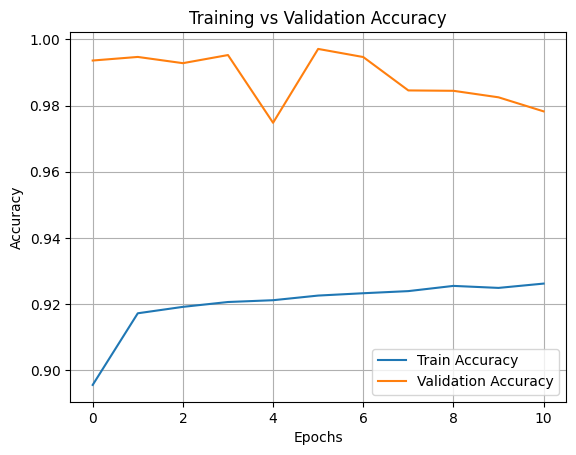

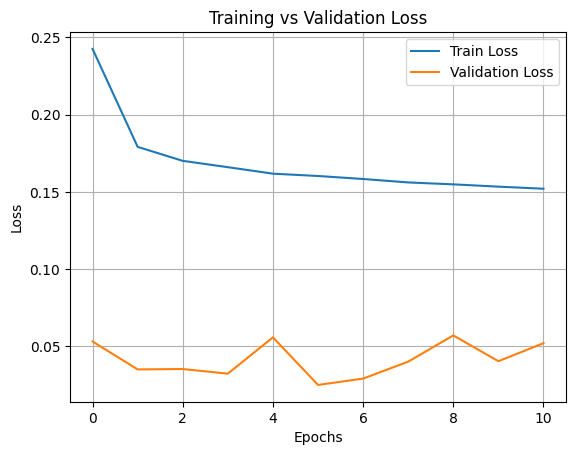

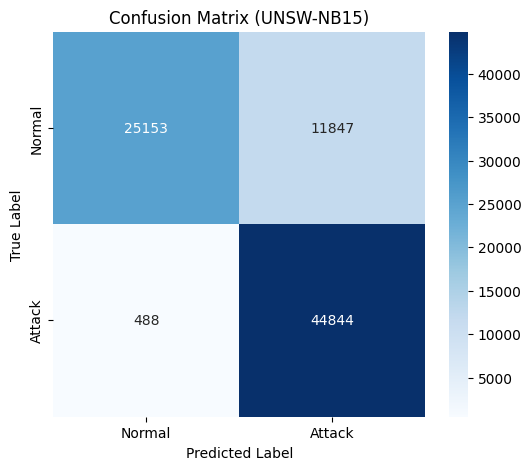

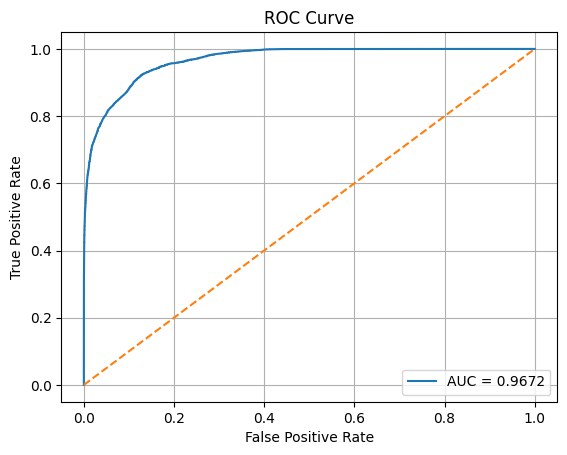

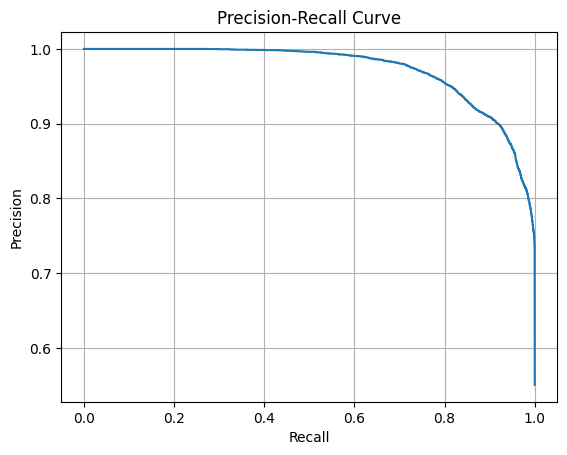


✅ ALL GRAPHS SAVED SUCCESSFULLY IN:
/content/graph_model


In [36]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve
)

# ===============================
# CREATE GRAPH FOLDER
# ===============================
GRAPH_DIR = "/content/graph_model"
os.makedirs(GRAPH_DIR, exist_ok=True)

# ===============================
# MODEL PREDICTION
# ===============================
y_prob = model.predict(X_test_selected).ravel()
y_pred = (y_prob > 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred))

# ===============================
# 1. ACCURACY CURVE
# ===============================
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.savefig(f"{GRAPH_DIR}/accuracy_curve.png", dpi=300, bbox_inches="tight")
plt.show()

# ===============================
# 2. LOSS CURVE
# ===============================
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.savefig(f"{GRAPH_DIR}/loss_curve.png", dpi=300, bbox_inches="tight")
plt.show()

# ===============================
# 3. CONFUSION MATRIX
# ===============================
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Normal", "Attack"],
    yticklabels=["Normal", "Attack"]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (UNSW-NB15)")
plt.savefig(f"{GRAPH_DIR}/confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

# ===============================
# 4. ROC CURVE
# ===============================
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.savefig(f"{GRAPH_DIR}/roc_curve.png", dpi=300, bbox_inches="tight")
plt.show()

# ===============================
# 5. PRECISION-RECALL CURVE
# ===============================
precision, recall, _ = precision_recall_curve(y_test, y_prob)

plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.savefig(f"{GRAPH_DIR}/precision_recall_curve.png", dpi=300, bbox_inches="tight")
plt.show()

print("\n✅ ALL GRAPHS SAVED SUCCESSFULLY IN:")
print(GRAPH_DIR)
